In [1]:
import torch
import anndata
import scanpy as sc
# import scarches as sca
import scvi


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Global seed set to 0


In [2]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [3]:
torch.cuda.is_available()

True

In [4]:
# no need to exclude villani, as loss is mse
adata = sc.read('../../data/immune/Immune_ALL_human.h5ad')
adata

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [5]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=4000,
    layer="counts",
    batch_key="batch",
    subset=True
)

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [6]:
# CD45 - marker of immune vs non-immune cells
np.array([x=='PTPRC' for x in adata.var_names.values.tolist()]).sum()

0

In [7]:
import pandas as pd
data = pd.read_table('../../data/tirosh_2016/GSE72056_melanoma_single_cell_revised_v2.txt')

In [8]:
meta_data = data.iloc[0:3,:]
gex_data = data.iloc[4:,:]
gex_data.index = gex_data.Cell
gex_data = gex_data.drop('Cell', axis = 1)

In [9]:
metadata_mapping = {'malignant' : {1 : 'no', 2:'yes', 0:'unresolved'},
                    'final_annotation' : {0: 'Malignant', 1:'T', 2:'B', 3:'Macro.', 4:'Endo.', 5:'CAF', 6:'NK'}}

In [10]:
obs = pd.DataFrame(data = {'Cell': gex_data.columns.tolist(),
                       'malignant': [int(x) for x in meta_data.iloc[1,1:].tolist()],
                       'final_annotation' : [int(x) for x in meta_data.iloc[2,1:].tolist()]})

In [11]:
obs = obs.replace(metadata_mapping)

In [12]:
query = sc.AnnData(gex_data)
query = query.T
query.obs = obs
query.obs['batch'] = 'query'
query

/tmp/ipykernel_8445/3248923236.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  query = sc.AnnData(gex_data)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4645 × 23685
    obs: 'Cell', 'malignant', 'final_annotation', 'batch'

In [13]:
# import re
# var_names = query.var_names.values
# query.var_names = [re.sub("\'",'', x) for x in var_names]

In [14]:
# intersection of reference and query
len(np.intersect1d(adata.var_names, query.var_names))

3997

In [15]:
query.obs['CD45'] = query[:,'PTPRC'].X

In [16]:
query.var_names_make_unique()

In [17]:
### padding non-overlapping genes with zero
X = np.concatenate(
    (
        query[:,np.intersect1d(adata.var_names,query.var_names)].X,
         np.zeros((query.shape[0], len(np.setdiff1d(adata.var_names, query.var_names))))
    ), axis = 1)

X.shape

(4645, 4000)

In [18]:
intersect_names = np.intersect1d(adata.var_names,query.var_names)
setdiff_names = np.setdiff1d(adata.var_names, query.var_names)

query = sc.AnnData(X, obs = query.obs)    
query.var_names = np.concatenate((intersect_names, setdiff_names))

/tmp/ipykernel_8445/98319506.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  query = sc.AnnData(X, obs = query.obs)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
query = query[:,adata.var_names]

In [20]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch")

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [21]:
# trvae = sca.models.TRVAE(
#     adata=adata,
#     condition_key='batch',
#     conditions= adata.obs['batch'].unique().tolist(),
#     hidden_layer_sizes=[128, 128],
#     recon_loss='mse',
# )

In [22]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

In [23]:
trvae = scvi.model.SCVI(
    adata=adata,
    **arches_params
 )

In [24]:
# trvae.train(
#     n_epochs=trvae_epochs,
#     alpha_epoch_anneal=200,
#     early_stopping_kwargs=early_stopping_kwargs
# )

In [25]:
# trvae.train(max_epochs=400, plan_kwargs=dict(weight_decay=0.0))

In [26]:
# trvae.save('immunemelanoma_scvi_model')

In [27]:
# ref_path = 'immune_exp_melanoma_4k_scarchesTrvae_mseloss/'
# trvae.save(ref_path, overwrite=True)


ref_path = '../../notebooks/immunemelanoma_scvi_model'
trvae = scvi.model.SCVI.load(ref_path, adata)


INFO     File ../../notebooks/immunemelanoma_scvi_model/model.pt already downloaded          


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [28]:
# trvae_q = sca.models.TRVAE.load_query_data(adata=query, 
#                                            reference_model=ref_path,
#                                           freeze_expression=False)

query = query.copy()

# trvae_q = scvi.model.SCVI.load_query_data(query, 
#                                             trvae)

In [29]:
# trvae_q.train(
#     n_epochs=surgery_epochs,
#     alpha_epoch_anneal=200,
#     early_stopping_kwargs=early_stopping_kwargs,
#     weight_decay=0
# )


# trvae_q.train(max_epochs=200, plan_kwargs=dict(weight_decay=0.0))

In [30]:
# trvae_q.save('immune_exp_melanoma_4k_scarchesTrvae_mseloss_trveacl_nofreezexprs')

In [31]:
query.obs_names = query.obs['Cell']

In [32]:
adata_full = query.concatenate(adata,batch_key="batch_nn")

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [33]:
adata_full

AnnData object with n_obs × n_vars = 38151 × 4000
    obs: 'Cell', 'malignant', 'final_annotation', 'batch', 'CD45', 'chemistry', 'data_type', 'dpt_pseudotime', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', '_scvi_batch', '_scvi_labels', 'batch_nn'
    var: 'highly_variable-1', 'highly_variable_rank-1', 'means-1', 'variances-1', 'variances_norm-1', 'highly_variable_nbatches-1'

In [34]:
adata_full.X = adata_full.X.todense()

In [35]:
# TL model (with or w/o freezing the expression layer)
# full_latent = sc.AnnData(trvae_q.get_latent(adata_full.X, adata_full.obs['batch']))
# full_latent = sc.AnnData(trvae_q.get_latent_representation(adata_full))
# full_latent.obs = adata_full.obs

In [36]:
# query.obs['fbatch'] = "10X"

In [37]:
# full_latent.uns['X_query_refproj_10X'] = trvae.get_latent(query.X, query.obs['fbatch'])

In [38]:
# adata_full.obs.batch.value_counts()

In [39]:
# query.obs['fbatch'] = "Villani"

In [40]:
# full_latent.uns['X_query_refproj_villani'] = trvae.get_latent(query.X, query.obs['fbatch'])

In [41]:
# full_latent

In [42]:
# full_latent.write('../data/tirosh_2016/tirosh_immune_4k_integrated_latent_scvi.h5ad')

In [43]:
# import umap

# X = full_latent.X
# trans = umap.UMAP(
#     n_neighbors=10,
#     random_state=42,
#     min_dist=0.4,
# )
# full_latent.obsm["X_umap"] = trans.fit_transform(X)

# trvae.umap_op_ = trans

In [44]:
# sc.pl.umap(
#     full_latent,
#     color=["batch", "final_annotation","CD45"],
#     frameon=False,
#     ncols=1,
# #     save = 'fig_4k_90masked_scarches.png'
# )

In [45]:
trvae_q = scvi.model.SCVI.load_query_data(query, 
                                            trvae)

# scvi.model.SCVI.setup_anndata(query, batch_key="batch")
# trvae_q = scvi.model.SCVI(query, **arches_params)

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [46]:
trvae_q

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.2, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [47]:
trvae

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.2, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [48]:
trvae_q.train(max_epochs=200, plan_kwargs=dict(weight_decay=0.0))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/200:   0%|          | 1/200 [00:01<03:40,  1.11s/it, loss=4.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/200:   1%|          | 2/200 [00:01<02:05,  1.58it/s, loss=4.67e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/200:   2%|▏         | 3/200 [00:01<01:33,  2.10it/s, loss=4.58e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/200:   2%|▏         | 4/200 [00:01<01:18,  2.50it/s, loss=4.49e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 6/200:   2%|▎         | 5/200 [00:02<01:09,  2.80it/s, loss=4.43e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/200:   3%|▎         | 6/200 [00:02<01:04,  3.01it/s, loss=4.38e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/200:   4%|▎         | 7/200 [00:02<01:01,  3.15it/s, loss=4.32e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/200:   4%|▍         | 8/200 [00:03<00:58,  3.27it/s, loss=4.27e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/200:   4%|▍         | 9/200 [00:03<00:56,  3.37it/s, loss=4.22e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/200:   5%|▌         | 10/200 [00:03<00:55,  3.42it/s, loss=4.21e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 12/200:   6%|▌         | 11/200 [00:03<00:54,  3.46it/s, loss=4.2e+03, v_num=1] 

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 13/200:   6%|▌         | 12/200 [00:04<00:53,  3.50it/s, loss=4.16e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 14/200:   6%|▋         | 13/200 [00:04<00:53,  3.50it/s, loss=4.14e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 15/200:   7%|▋         | 14/200 [00:04<00:52,  3.53it/s, loss=4.12e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 16/200:   8%|▊         | 15/200 [00:05<00:52,  3.52it/s, loss=4.09e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 17/200:   8%|▊         | 16/200 [00:05<00:52,  3.53it/s, loss=4.07e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 18/200:   8%|▊         | 17/200 [00:05<00:51,  3.55it/s, loss=4.08e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 19/200:   9%|▉         | 18/200 [00:05<00:51,  3.52it/s, loss=4.08e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/200:  10%|▉         | 19/200 [00:06<00:51,  3.51it/s, loss=4.05e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 21/200:  10%|█         | 20/200 [00:06<00:51,  3.52it/s, loss=4.03e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 22/200:  10%|█         | 21/200 [00:06<00:50,  3.52it/s, loss=4.02e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 23/200:  11%|█         | 22/200 [00:07<00:50,  3.50it/s, loss=4.01e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 24/200:  12%|█▏        | 23/200 [00:07<00:50,  3.48it/s, loss=4.02e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/200:  12%|█▏        | 24/200 [00:07<00:50,  3.50it/s, loss=4.01e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 26/200:  12%|█▎        | 25/200 [00:07<00:49,  3.52it/s, loss=3.99e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 27/200:  13%|█▎        | 26/200 [00:08<00:48,  3.56it/s, loss=3.99e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 28/200:  14%|█▎        | 27/200 [00:08<00:48,  3.54it/s, loss=4e+03, v_num=1]   

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 29/200:  14%|█▍        | 28/200 [00:08<00:48,  3.55it/s, loss=3.96e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 30/200:  14%|█▍        | 29/200 [00:09<00:47,  3.57it/s, loss=3.97e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 31/200:  15%|█▌        | 30/200 [00:09<00:47,  3.58it/s, loss=3.96e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 32/200:  16%|█▌        | 31/200 [00:09<00:47,  3.58it/s, loss=3.95e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 33/200:  16%|█▌        | 32/200 [00:09<00:46,  3.64it/s, loss=3.95e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 34/200:  16%|█▋        | 33/200 [00:10<00:45,  3.65it/s, loss=3.95e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 35/200:  17%|█▋        | 34/200 [00:10<00:45,  3.67it/s, loss=3.93e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 36/200:  18%|█▊        | 35/200 [00:10<00:44,  3.67it/s, loss=3.94e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 37/200:  18%|█▊        | 36/200 [00:10<00:45,  3.63it/s, loss=3.96e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 38/200:  18%|█▊        | 37/200 [00:11<00:44,  3.67it/s, loss=3.93e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 39/200:  19%|█▉        | 38/200 [00:11<00:43,  3.70it/s, loss=3.94e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 40/200:  20%|█▉        | 39/200 [00:11<00:43,  3.72it/s, loss=3.92e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 41/200:  20%|██        | 40/200 [00:12<00:42,  3.73it/s, loss=3.92e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 42/200:  20%|██        | 41/200 [00:12<00:44,  3.55it/s, loss=3.93e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 43/200:  21%|██        | 42/200 [00:12<00:46,  3.41it/s, loss=3.93e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 44/200:  22%|██▏       | 43/200 [00:12<00:47,  3.32it/s, loss=3.91e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 45/200:  22%|██▏       | 44/200 [00:13<00:46,  3.38it/s, loss=3.9e+03, v_num=1] 

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 46/200:  22%|██▎       | 45/200 [00:13<00:44,  3.46it/s, loss=3.91e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 47/200:  23%|██▎       | 46/200 [00:13<00:43,  3.51it/s, loss=3.92e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 48/200:  24%|██▎       | 47/200 [00:14<00:42,  3.58it/s, loss=3.91e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 49/200:  24%|██▍       | 48/200 [00:14<00:42,  3.59it/s, loss=3.89e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 50/200:  24%|██▍       | 49/200 [00:14<00:42,  3.56it/s, loss=3.89e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 51/200:  25%|██▌       | 50/200 [00:14<00:41,  3.59it/s, loss=3.88e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 52/200:  26%|██▌       | 51/200 [00:15<00:41,  3.58it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 53/200:  26%|██▌       | 52/200 [00:15<00:41,  3.58it/s, loss=3.88e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 54/200:  26%|██▋       | 53/200 [00:15<00:40,  3.59it/s, loss=3.88e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 55/200:  27%|██▋       | 54/200 [00:16<00:40,  3.60it/s, loss=3.89e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 56/200:  28%|██▊       | 55/200 [00:16<00:40,  3.60it/s, loss=3.89e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 57/200:  28%|██▊       | 56/200 [00:16<00:40,  3.58it/s, loss=3.88e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 58/200:  28%|██▊       | 57/200 [00:16<00:39,  3.58it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 59/200:  29%|██▉       | 58/200 [00:17<00:40,  3.53it/s, loss=3.9e+03, v_num=1] 

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 60/200:  30%|██▉       | 59/200 [00:17<00:40,  3.50it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 61/200:  30%|███       | 60/200 [00:17<00:39,  3.52it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 62/200:  30%|███       | 61/200 [00:18<00:39,  3.53it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 63/200:  31%|███       | 62/200 [00:18<00:38,  3.55it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 64/200:  32%|███▏      | 63/200 [00:18<00:38,  3.52it/s, loss=3.88e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 65/200:  32%|███▏      | 64/200 [00:18<00:40,  3.35it/s, loss=3.88e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 66/200:  32%|███▎      | 65/200 [00:19<00:40,  3.35it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 67/200:  33%|███▎      | 66/200 [00:19<00:38,  3.45it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 68/200:  34%|███▎      | 67/200 [00:19<00:37,  3.52it/s, loss=3.86e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 69/200:  34%|███▍      | 68/200 [00:20<00:37,  3.56it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 70/200:  34%|███▍      | 69/200 [00:20<00:36,  3.61it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 71/200:  35%|███▌      | 70/200 [00:20<00:35,  3.63it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 72/200:  36%|███▌      | 71/200 [00:20<00:35,  3.63it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 73/200:  36%|███▌      | 72/200 [00:21<00:35,  3.63it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 74/200:  36%|███▋      | 73/200 [00:21<00:34,  3.65it/s, loss=3.88e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 75/200:  37%|███▋      | 74/200 [00:21<00:34,  3.69it/s, loss=3.86e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 76/200:  38%|███▊      | 75/200 [00:21<00:33,  3.68it/s, loss=3.86e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 77/200:  38%|███▊      | 76/200 [00:22<00:33,  3.68it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 78/200:  38%|███▊      | 77/200 [00:22<00:33,  3.66it/s, loss=3.86e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 79/200:  39%|███▉      | 78/200 [00:22<00:33,  3.62it/s, loss=3.86e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 80/200:  40%|███▉      | 79/200 [00:23<00:33,  3.65it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 81/200:  40%|████      | 80/200 [00:23<00:33,  3.59it/s, loss=3.86e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 82/200:  40%|████      | 81/200 [00:23<00:32,  3.62it/s, loss=3.86e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 83/200:  41%|████      | 82/200 [00:23<00:32,  3.62it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 84/200:  42%|████▏     | 83/200 [00:24<00:32,  3.62it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 85/200:  42%|████▏     | 84/200 [00:24<00:32,  3.60it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 86/200:  42%|████▎     | 85/200 [00:24<00:31,  3.64it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 87/200:  43%|████▎     | 86/200 [00:25<00:32,  3.48it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 88/200:  44%|████▎     | 87/200 [00:25<00:32,  3.53it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 89/200:  44%|████▍     | 88/200 [00:25<00:31,  3.58it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 90/200:  44%|████▍     | 89/200 [00:25<00:30,  3.61it/s, loss=3.87e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 91/200:  45%|████▌     | 90/200 [00:26<00:30,  3.56it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 92/200:  46%|████▌     | 91/200 [00:26<00:30,  3.58it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 93/200:  46%|████▌     | 92/200 [00:26<00:30,  3.58it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 94/200:  46%|████▋     | 93/200 [00:26<00:29,  3.58it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 95/200:  47%|████▋     | 94/200 [00:27<00:29,  3.58it/s, loss=3.82e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 96/200:  48%|████▊     | 95/200 [00:27<00:29,  3.58it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 97/200:  48%|████▊     | 96/200 [00:27<00:29,  3.58it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 98/200:  48%|████▊     | 97/200 [00:28<00:28,  3.57it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 99/200:  49%|████▉     | 98/200 [00:28<00:28,  3.58it/s, loss=3.86e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/200:  50%|████▉     | 99/200 [00:28<00:28,  3.59it/s, loss=3.86e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 101/200:  50%|█████     | 100/200 [00:28<00:27,  3.59it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 102/200:  50%|█████     | 101/200 [00:29<00:27,  3.59it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 103/200:  51%|█████     | 102/200 [00:29<00:27,  3.58it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 104/200:  52%|█████▏    | 103/200 [00:29<00:26,  3.61it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 105/200:  52%|█████▏    | 104/200 [00:30<00:26,  3.60it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 106/200:  52%|█████▎    | 105/200 [00:30<00:26,  3.58it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 107/200:  53%|█████▎    | 106/200 [00:30<00:25,  3.62it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 108/200:  54%|█████▎    | 107/200 [00:30<00:25,  3.66it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 109/200:  54%|█████▍    | 108/200 [00:31<00:25,  3.67it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 110/200:  55%|█████▍    | 109/200 [00:31<00:24,  3.72it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 111/200:  55%|█████▌    | 110/200 [00:31<00:24,  3.75it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 112/200:  56%|█████▌    | 111/200 [00:31<00:23,  3.77it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 113/200:  56%|█████▌    | 112/200 [00:32<00:23,  3.79it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 114/200:  56%|█████▋    | 113/200 [00:32<00:22,  3.81it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 115/200:  57%|█████▋    | 114/200 [00:32<00:22,  3.82it/s, loss=3.86e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 116/200:  57%|█████▊    | 115/200 [00:32<00:22,  3.82it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 117/200:  58%|█████▊    | 116/200 [00:33<00:21,  3.83it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 118/200:  58%|█████▊    | 117/200 [00:33<00:21,  3.81it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 119/200:  59%|█████▉    | 118/200 [00:33<00:21,  3.79it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 120/200:  60%|█████▉    | 119/200 [00:34<00:22,  3.62it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 121/200:  60%|██████    | 120/200 [00:34<00:23,  3.48it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 122/200:  60%|██████    | 121/200 [00:34<00:23,  3.41it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 123/200:  61%|██████    | 122/200 [00:34<00:22,  3.50it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 124/200:  62%|██████▏   | 123/200 [00:35<00:21,  3.56it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 125/200:  62%|██████▏   | 124/200 [00:35<00:21,  3.61it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 126/200:  62%|██████▎   | 125/200 [00:35<00:20,  3.64it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 127/200:  63%|██████▎   | 126/200 [00:35<00:20,  3.66it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 128/200:  64%|██████▎   | 127/200 [00:36<00:19,  3.65it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 129/200:  64%|██████▍   | 128/200 [00:36<00:19,  3.64it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 130/200:  64%|██████▍   | 129/200 [00:36<00:19,  3.65it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 131/200:  65%|██████▌   | 130/200 [00:37<00:18,  3.68it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 132/200:  66%|██████▌   | 131/200 [00:37<00:18,  3.71it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 133/200:  66%|██████▌   | 132/200 [00:37<00:18,  3.72it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 134/200:  66%|██████▋   | 133/200 [00:37<00:17,  3.74it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 135/200:  67%|██████▋   | 134/200 [00:38<00:17,  3.74it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 136/200:  68%|██████▊   | 135/200 [00:38<00:17,  3.76it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 137/200:  68%|██████▊   | 136/200 [00:38<00:16,  3.77it/s, loss=3.82e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 138/200:  68%|██████▊   | 137/200 [00:38<00:16,  3.75it/s, loss=3.82e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 139/200:  69%|██████▉   | 138/200 [00:39<00:16,  3.78it/s, loss=3.86e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 140/200:  70%|██████▉   | 139/200 [00:39<00:16,  3.75it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 141/200:  70%|███████   | 140/200 [00:39<00:16,  3.71it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 142/200:  70%|███████   | 141/200 [00:40<00:15,  3.69it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 143/200:  71%|███████   | 142/200 [00:40<00:15,  3.69it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 144/200:  72%|███████▏  | 143/200 [00:40<00:15,  3.70it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 145/200:  72%|███████▏  | 144/200 [00:40<00:15,  3.70it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 146/200:  72%|███████▎  | 145/200 [00:41<00:14,  3.71it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 147/200:  73%|███████▎  | 146/200 [00:41<00:14,  3.72it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 148/200:  74%|███████▎  | 147/200 [00:41<00:14,  3.72it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 149/200:  74%|███████▍  | 148/200 [00:41<00:13,  3.74it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 150/200:  74%|███████▍  | 149/200 [00:42<00:13,  3.74it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 151/200:  75%|███████▌  | 150/200 [00:42<00:13,  3.74it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 152/200:  76%|███████▌  | 151/200 [00:42<00:13,  3.73it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 153/200:  76%|███████▌  | 152/200 [00:42<00:12,  3.70it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 154/200:  76%|███████▋  | 153/200 [00:43<00:12,  3.73it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 155/200:  77%|███████▋  | 154/200 [00:43<00:12,  3.73it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 156/200:  78%|███████▊  | 155/200 [00:43<00:12,  3.74it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 157/200:  78%|███████▊  | 156/200 [00:44<00:11,  3.73it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 158/200:  78%|███████▊  | 157/200 [00:44<00:11,  3.73it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 159/200:  79%|███████▉  | 158/200 [00:44<00:11,  3.73it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 160/200:  80%|███████▉  | 159/200 [00:44<00:11,  3.73it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 161/200:  80%|████████  | 160/200 [00:45<00:10,  3.71it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 162/200:  80%|████████  | 161/200 [00:45<00:10,  3.72it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 163/200:  81%|████████  | 162/200 [00:45<00:10,  3.71it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 164/200:  82%|████████▏ | 163/200 [00:45<00:09,  3.73it/s, loss=3.82e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 165/200:  82%|████████▏ | 164/200 [00:46<00:09,  3.71it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 166/200:  82%|████████▎ | 165/200 [00:46<00:09,  3.68it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 167/200:  83%|████████▎ | 166/200 [00:46<00:09,  3.70it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 168/200:  84%|████████▎ | 167/200 [00:47<00:08,  3.71it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 169/200:  84%|████████▍ | 168/200 [00:47<00:08,  3.71it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 170/200:  84%|████████▍ | 169/200 [00:47<00:08,  3.71it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 171/200:  85%|████████▌ | 170/200 [00:47<00:08,  3.72it/s, loss=3.82e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 172/200:  86%|████████▌ | 171/200 [00:48<00:07,  3.72it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 173/200:  86%|████████▌ | 172/200 [00:48<00:07,  3.71it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 174/200:  86%|████████▋ | 173/200 [00:48<00:07,  3.70it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 175/200:  87%|████████▋ | 174/200 [00:48<00:07,  3.70it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 176/200:  88%|████████▊ | 175/200 [00:49<00:06,  3.71it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 177/200:  88%|████████▊ | 176/200 [00:49<00:06,  3.69it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 178/200:  88%|████████▊ | 177/200 [00:49<00:06,  3.72it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 179/200:  89%|████████▉ | 178/200 [00:49<00:06,  3.66it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 180/200:  90%|████████▉ | 179/200 [00:50<00:05,  3.67it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 181/200:  90%|█████████ | 180/200 [00:50<00:05,  3.65it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 182/200:  90%|█████████ | 181/200 [00:50<00:05,  3.63it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 183/200:  91%|█████████ | 182/200 [00:51<00:04,  3.64it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 184/200:  92%|█████████▏| 183/200 [00:51<00:04,  3.62it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 185/200:  92%|█████████▏| 184/200 [00:51<00:04,  3.62it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 186/200:  92%|█████████▎| 185/200 [00:51<00:04,  3.59it/s, loss=3.85e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 187/200:  93%|█████████▎| 186/200 [00:52<00:03,  3.60it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 188/200:  94%|█████████▎| 187/200 [00:52<00:03,  3.61it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 189/200:  94%|█████████▍| 188/200 [00:52<00:03,  3.59it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 190/200:  94%|█████████▍| 189/200 [00:53<00:03,  3.57it/s, loss=3.82e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 191/200:  95%|█████████▌| 190/200 [00:53<00:02,  3.55it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 192/200:  96%|█████████▌| 191/200 [00:53<00:02,  3.53it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 193/200:  96%|█████████▌| 192/200 [00:53<00:02,  3.56it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 194/200:  96%|█████████▋| 193/200 [00:54<00:01,  3.57it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 195/200:  97%|█████████▋| 194/200 [00:54<00:01,  3.58it/s, loss=3.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 196/200:  98%|█████████▊| 195/200 [00:54<00:01,  3.59it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 197/200:  98%|█████████▊| 196/200 [00:55<00:01,  3.60it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 198/200:  98%|█████████▊| 197/200 [00:55<00:00,  3.62it/s, loss=3.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 199/200:  99%|█████████▉| 198/200 [00:55<00:00,  3.54it/s, loss=3.82e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 200/200: 100%|█████████▉| 199/200 [00:55<00:00,  3.55it/s, loss=3.82e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 200/200: 100%|██████████| 200/200 [00:56<00:00,  3.56it/s, loss=3.84e+03, v_num=1]


In [49]:
adata_ = adata.copy()
# adata_.obs.batch = "query"

adata_.obs['batch_orig'] = adata.obs.batch
query.obs['batch_orig'] = query.obs.batch

In [50]:
adata_full = query.concatenate(adata_, batch_key="batch_nn")

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [51]:
full_latent = sc.AnnData(trvae_q.get_latent_representation(adata_full))
full_latent.obs = adata_full.obs

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [52]:
full_latent.obs['batch_type']=['query' if x=='query' else 'reference' for x in full_latent.obs.batch_orig]

In [53]:
import umap

X = full_latent.X
trans = umap.UMAP(
    n_neighbors=10,
    random_state=42,
    min_dist=0.4,
)
full_latent.obsm["X_umap"] = trans.fit_transform(X)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Figure size 320x320 with 0 Axes>

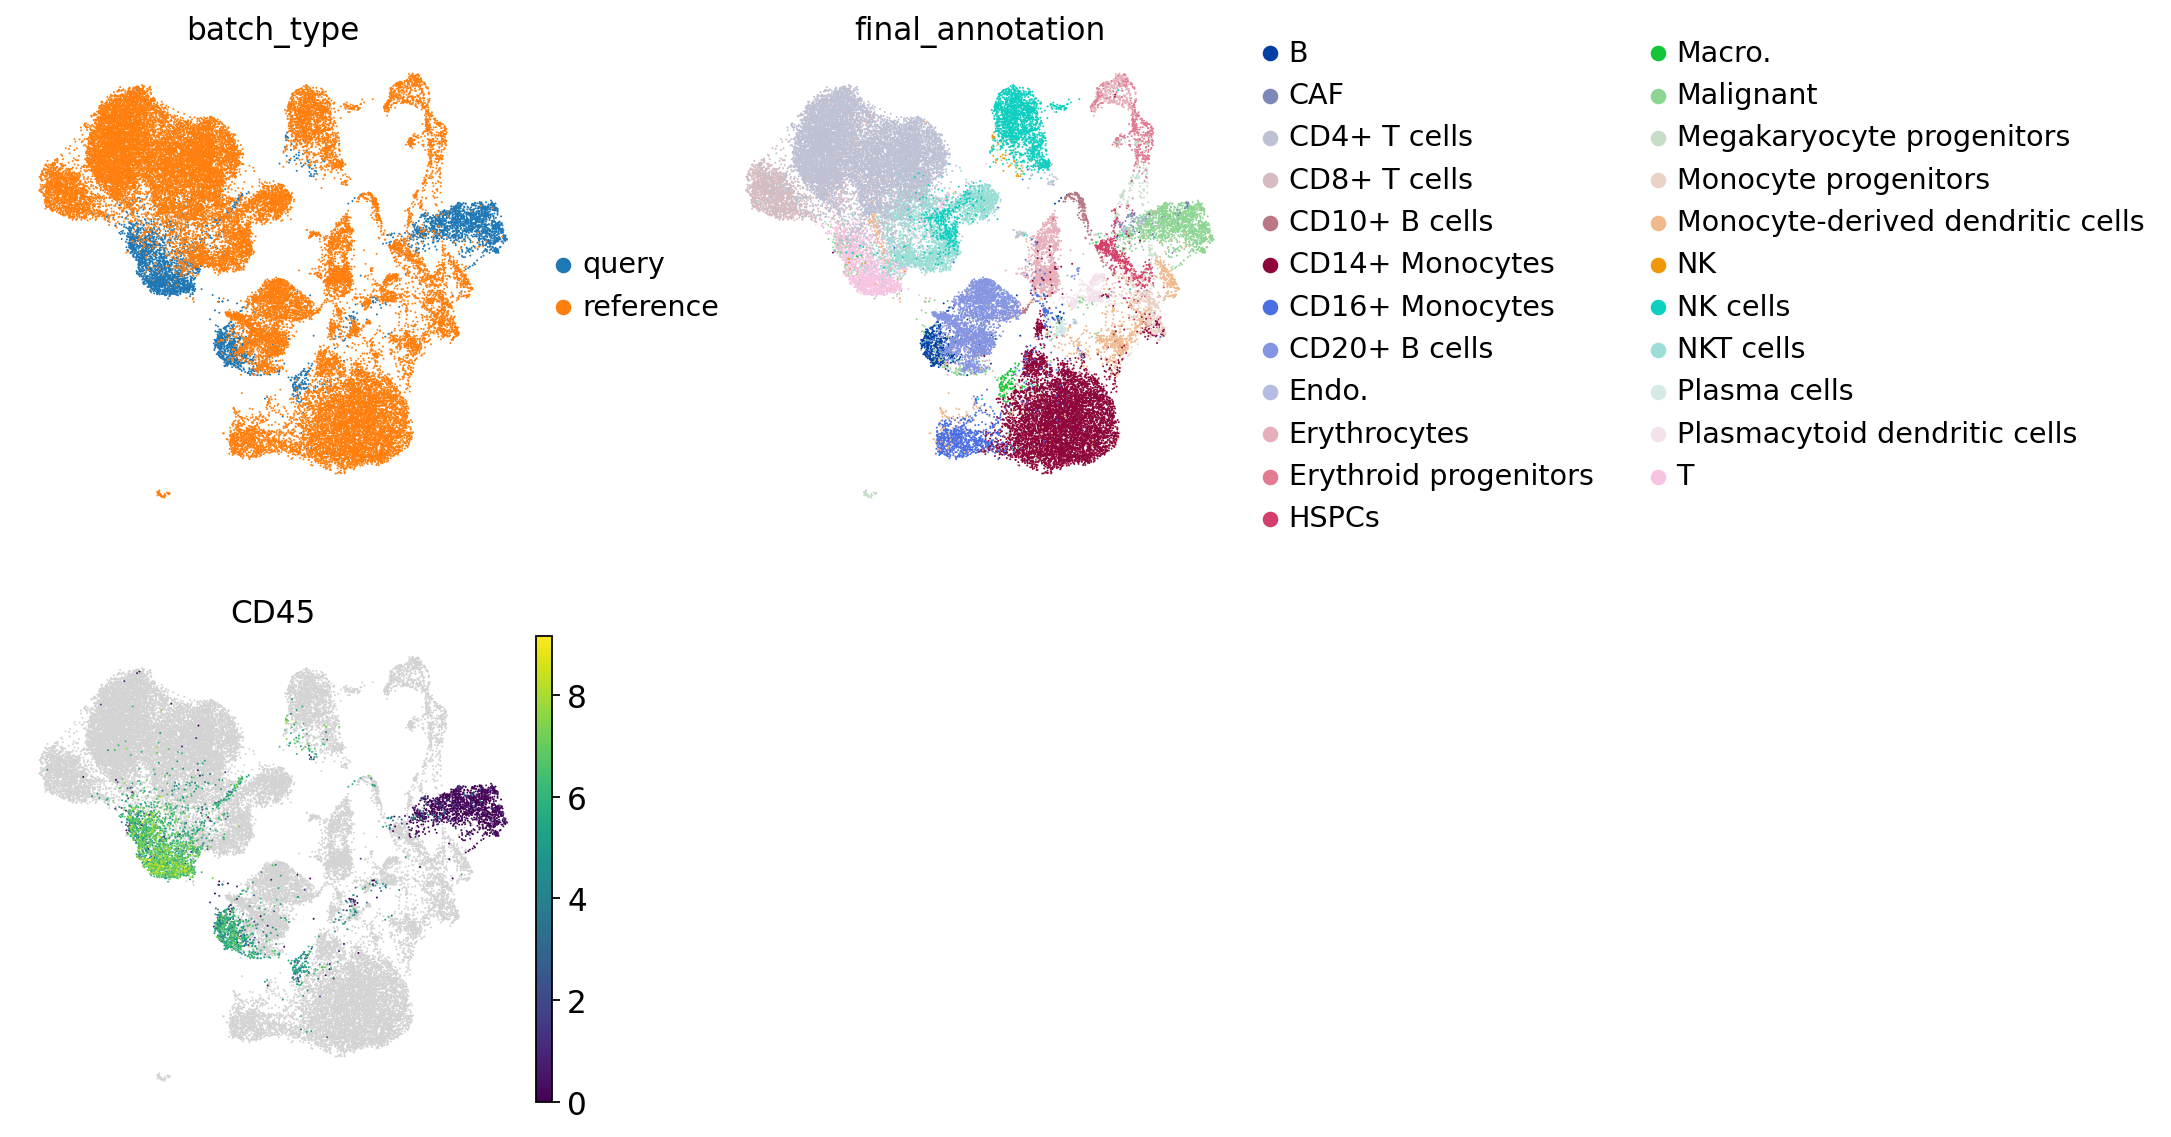

In [54]:
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch_type", "final_annotation","CD45"],
    wspace= 0.25,
    frameon=False,
    ncols=2,
#     save = 'fig_tirosh_4k_integrated_scvi_cl_newmodel_midlayers.png'
)

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


<Figure size 320x320 with 0 Axes>

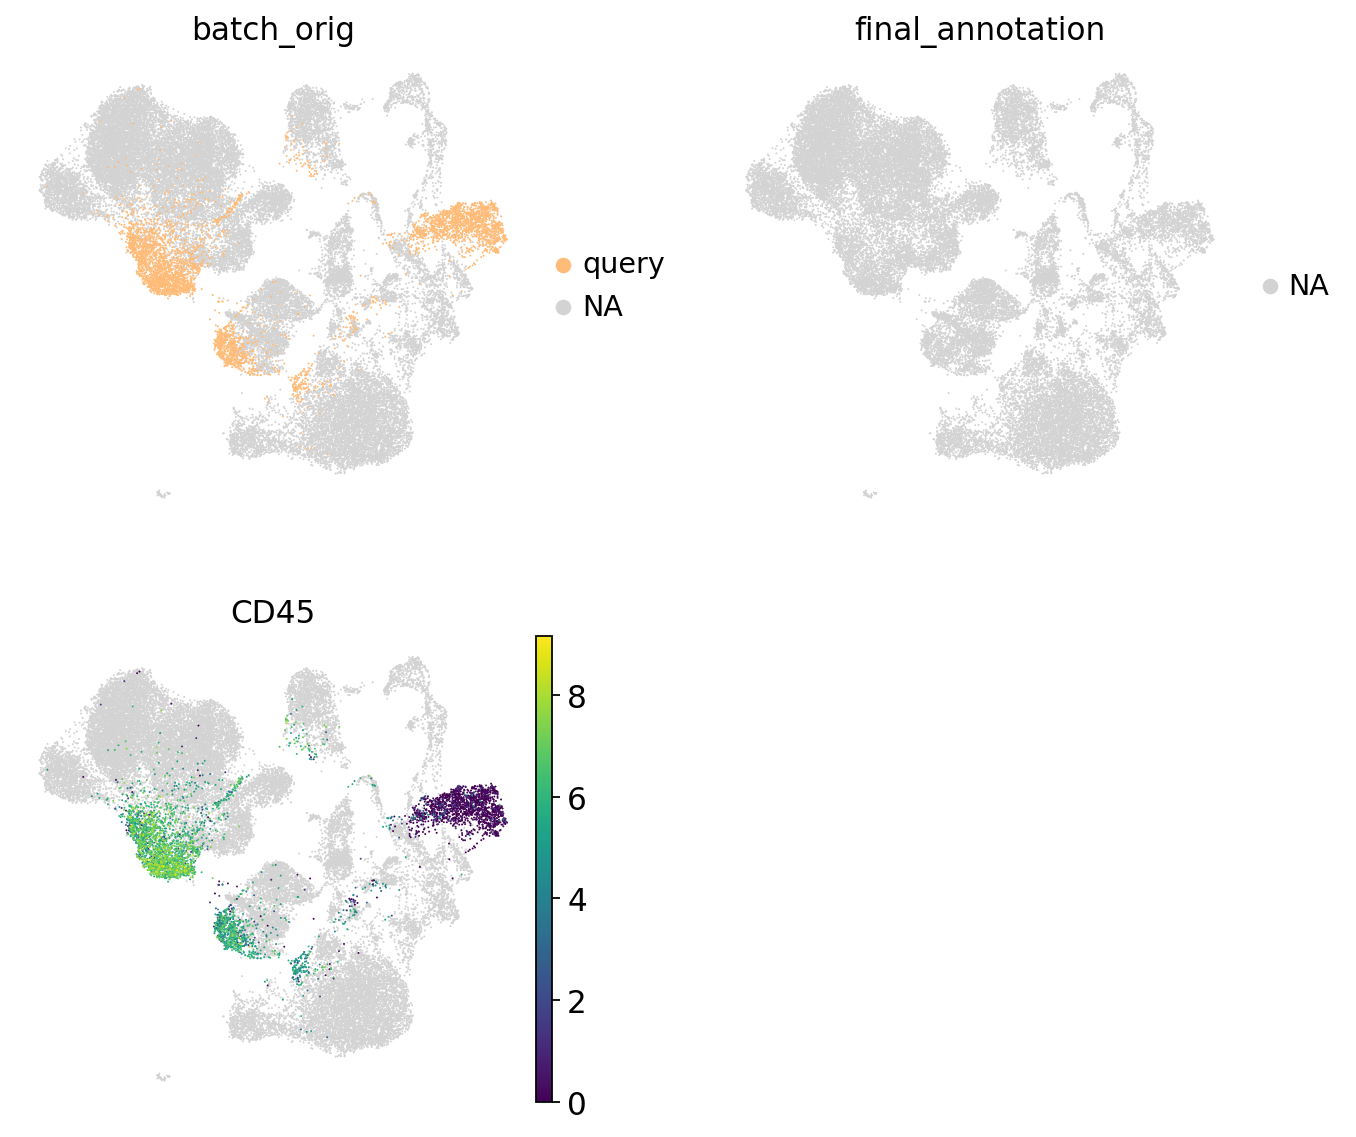

In [55]:
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch_orig", "final_annotation","CD45"],
    groups = ['query'],
    wspace= 0.25,
    frameon=False,
    ncols=2,
)

In [56]:
ref_adata = full_latent[full_latent.obs.batch_type == 'reference'].copy()
query_adata = full_latent[full_latent.obs.batch_type == 'query'].copy()

In [57]:
import pynndescent

X_train = ref_adata.X
ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

import numba

query_emb = query_adata

ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(
    ref_distances_tilda, axis=1, keepdims=True
)

@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

# get prediction and uncertainty
l = 'final_annotation'
ref_cats = ref_adata.obs[l].cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(ref_adata.obs[l].cat.categories)[p]
query_emb.obs[l + "_pred"], query_emb.obs[l + "_uncertainty"] = p, u


uncertainty_threshold = 0.3
mask = query_emb.obs[l + "_uncertainty"] > uncertainty_threshold
print(f"{l}: {sum(mask)/len(mask)} unknown")
query_emb.obs[l + "_pred"].loc[mask] = "Unknown"

query_adata.obs = query_emb.obs

final_annotation: 0.3733046286329386 unknown


/tmp/ipykernel_8445/2214044460.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_emb.obs[l + "_pred"].loc[mask] = "Unknown"


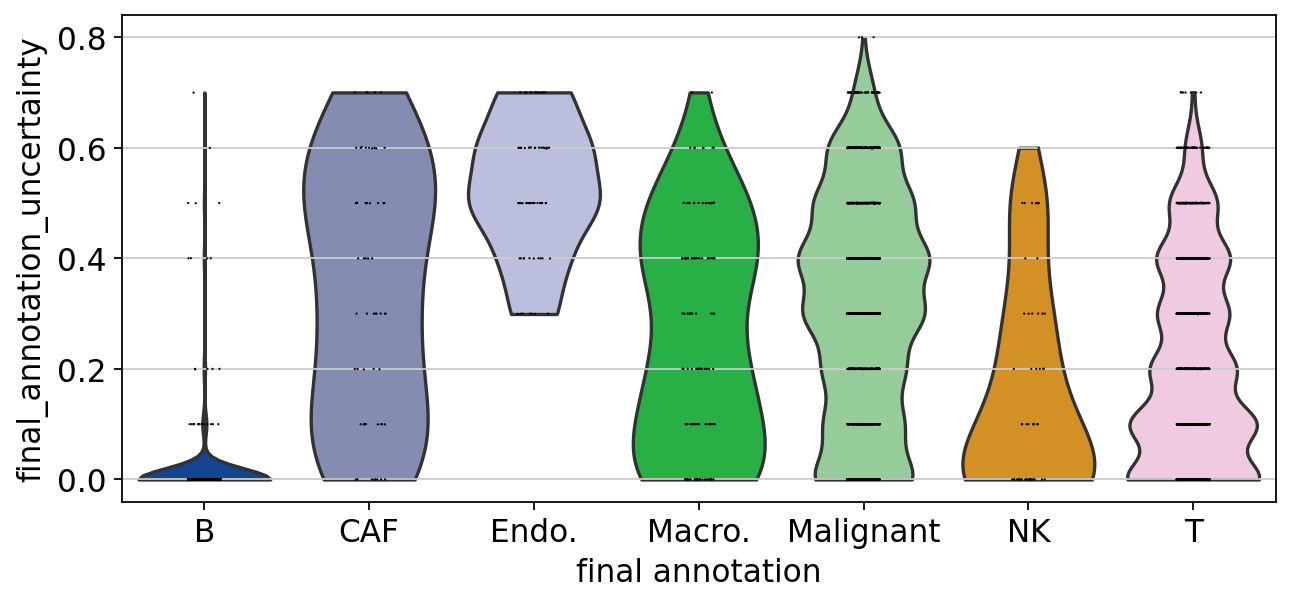

In [58]:
sc.set_figure_params(figsize=(8, 4))
sc.pl.violin(query_adata, ['final_annotation_uncertainty'], groupby='final_annotation',
            save = '_melanoma_surgery_uncertainty_scores.png')

In [59]:
import pandas as pd
df = pd.crosstab(query_adata.obs.final_annotation, query_adata.obs.final_annotation_pred)

/tmp/ipykernel_8445/1151892715.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = plt.pcolor(scaler.transform(df.T.to_numpy()))


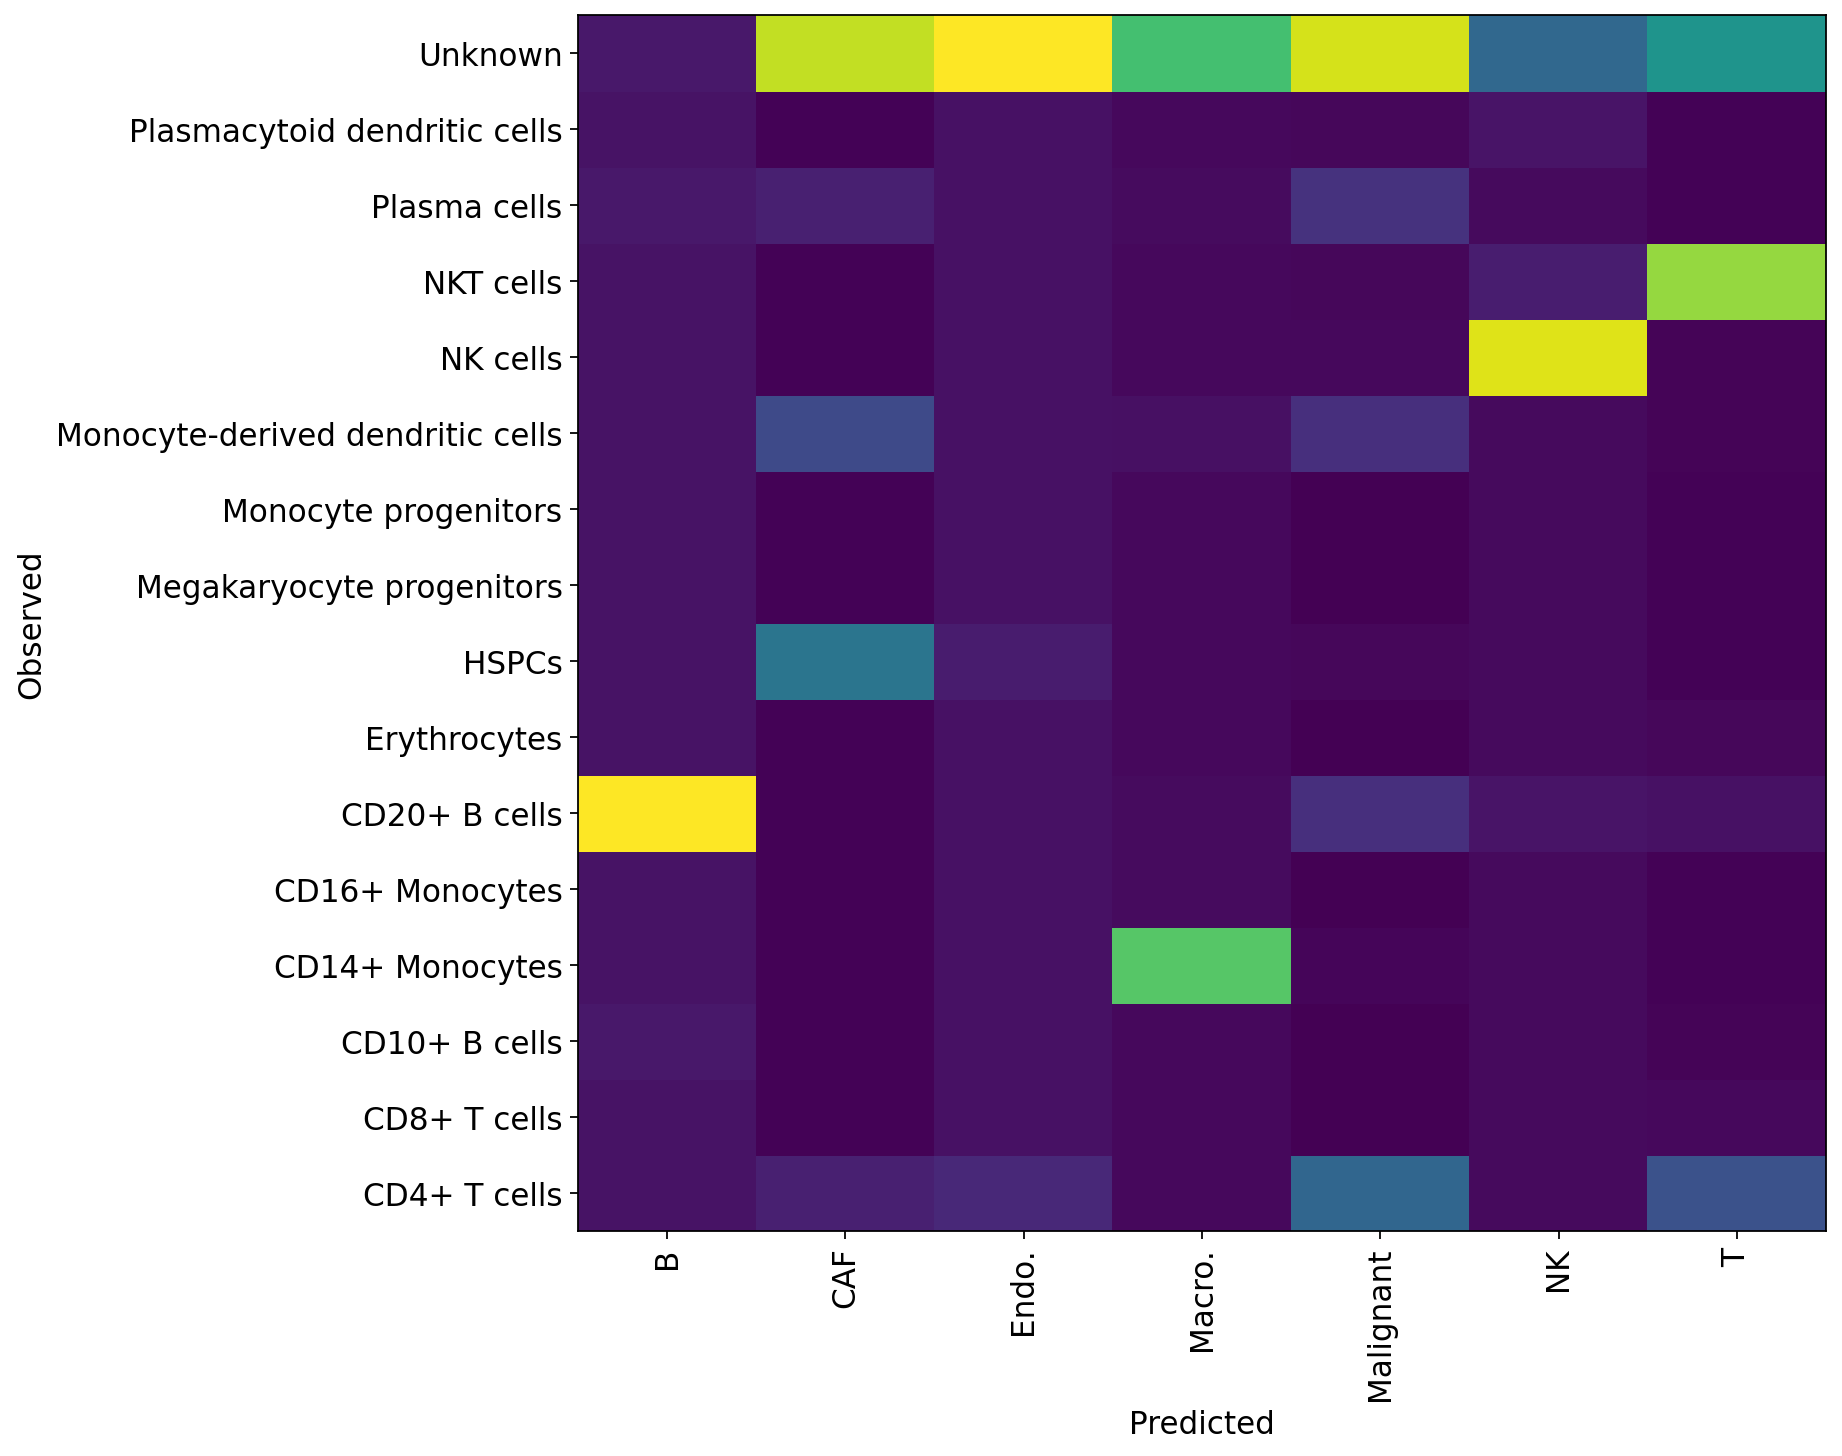

In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.T.to_numpy())

plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10, 10))
_ = plt.pcolor(scaler.transform(df.T.to_numpy()))
_ = plt.xticks(np.arange(0.5, len(df.index), 1), df.index, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.savefig('figures/melanoma_pynn_predictions_heatmap_surgery.png')

In [61]:
# full_latent.write('../data/tirosh_2016/tirosh_immune_4k_integrated_latent_cl_weightelosses_newmodel_meanencoderlayer.h5ad')